## Useful libraries


In [29]:
%matplotlib inline                  
import matplotlib                   # make plots show up in notebook
import time                         # time/date parser
import csv                          # data parser
import numpy as np                  # arrays for plotting
import matplotlib.pyplot as plt     # plotting
import math                         # ceiling for y-max in plots
import twittercriteria as twc       # yaml, re, os

import os
import sys
sys.path.append(os.path.realpath('../census/'))
import bostonmap2 as bm
sys.path.append(os.path.realpath('./classifiers/'))
import relevanceclassifier as rc
import posnegclassifier as pnc


## Retrieving useful data with our `twitter_criteria` module

In [30]:
# retrieve the time format string from the criteria dictionary in twc
tweet_time_fmt = twc.getTwitterTimeFmt()

# build regex pattern for searching for all the keywords
# Will look something like '#bostonmarathon|#marathonmonday|#patriotsday|marathon|...'
keywords = twc.getKeywordRegex()

# initialze hash/dictionary for counting keyword occurances
keyword_counts = {}
for word in twc.getKeywords():
    keyword_counts[word] = {'frequency':0, 'tweets':0}


## Functions

In [31]:

def tweetContainsKeyWords(tweet):
    # searches tweet for keywords, if none were found, findall returns empty list
    found_words = keywords.findall(tweet)
    if found_words:
        for word in found_words:
            keyword_counts[word]['frequency'] += 1
        for word in set(found_words):
            keyword_counts[word]['tweets'] += 1
        return True
    else:
        return False

def makePlot(dates, month, title, outfile, maxc, colors):
    ### produce subplots
    ### source: http://people.duke.edu/~ccc14/pcfb/numpympl/MatplotlibBarPlots.html
  
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(121) # 1x2 grid, 1st subplot

    #### make data plot-friendly

    bar_width = 0.35
    indices = np.arange(len(dates))

    ams = []
    pms = []
    tickMarks = []

    # goes through the date hashes in order of day
    for d in sorted(dates):
        # adds the day's counts to each list respectively
        ams.append(dates[d]['AM'])
        pms.append(dates[d]['PM'])
        # make string representing and add it to list
        tickMarks.append(str(month) + '/' + str(d))

    ##### get largest count of both lists and round up to nearest 100th
    maxCount = int(math.ceil(max(ams + pms) / 1000.0)) * 1000

    #### plot data

    ##### first plot

    amBars = ax.bar(indices, ams, bar_width, color=colors['AM'])

    pmBars = ax.bar(indices+bar_width, pms, bar_width, color=colors['PM'])

    ax.set_xlim(-bar_width, len(indices)+bar_width)
    ax.set_ylim(0, maxc)
    ax.set_ylabel('Number of Tweets')
    ax.set_title(title, fontsize=10)
    ax.set_xticks(indices+bar_width)
    tickNames = ax.set_xticklabels(tickMarks)
    plt.setp(tickNames, rotation=45, fontsize=10)

    ax.legend((amBars[0], pmBars[0]), ('AM', 'PM'))

    ##### second plot, keyword count
    #source (simple way): http://stackoverflow.com/questions/17232683/creating-tables-in-matplotlib
    
    colLabs = ['Keyword', 'Frequency', '# Tweets']

    table_data = []
    for word in sorted(keyword_counts, key=keyword_counts.get, reverse=True):
        table_data.append([word, keyword_counts[word]['frequency'], keyword_counts[word]['tweets']])
    
    ax2 = fig.add_subplot(122) # 1x2, 2nd subplot
    ax2.axis('off') # makes blank subplot
    
    # add title and text
    ax2.set_title('Frequencies of Keywords')
    table = ax2.table(loc='center', colLabels=colLabs, cellText=table_data)
    table.set_fontsize(14)
    table.scale(1.2,1.2)
    
    #### save plots as image
    plt.savefig(outfile, dpi=96)
    return


## Main

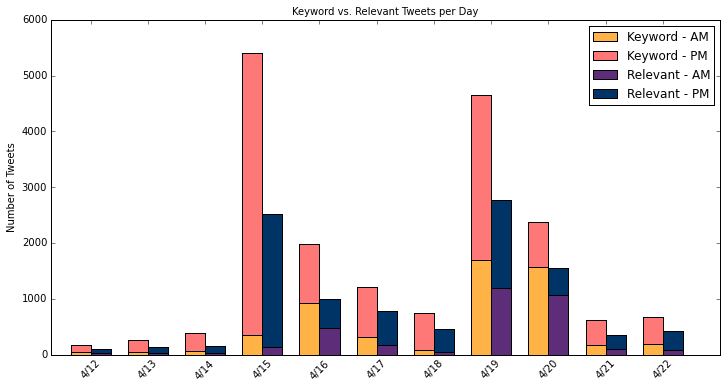

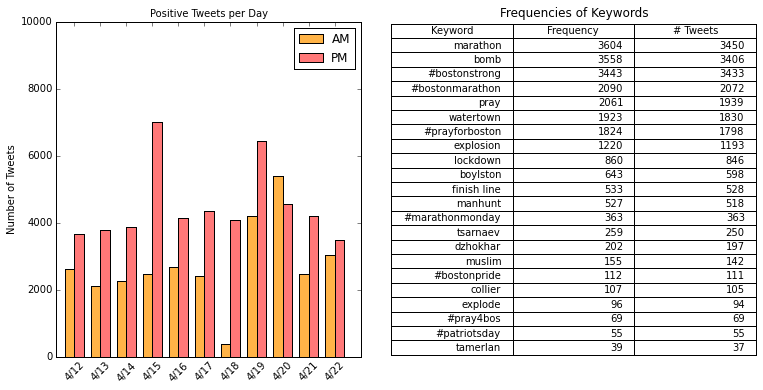

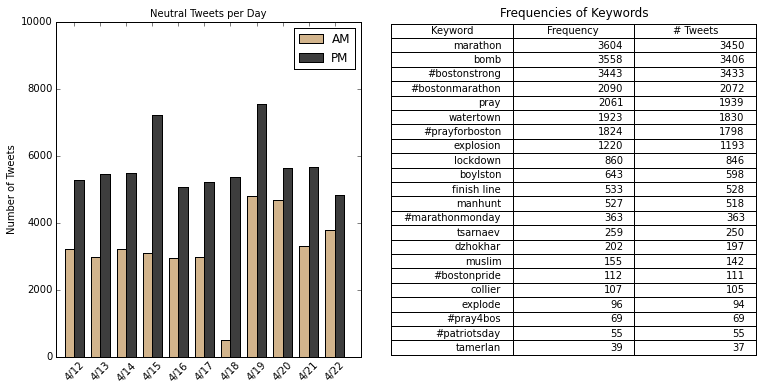

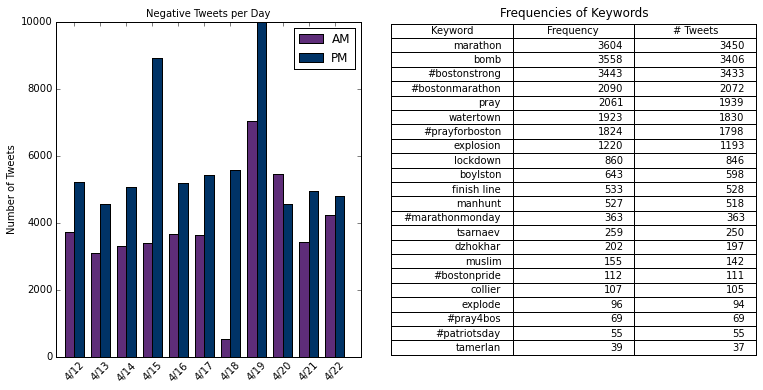

In [32]:
def main():

    ### get data

    kwDates = {}
    kwTweets = []
    
    relTweets = []
    relDates = {}
    
    tweetList = []
    
    textList= []

    trainingPaths = {'relevant':'/relevanceData/relevant.txt', 'irrelevant':'/relevanceData/irrelevant.txt'}
    
    paths = {'positive':'/sentimentData/positive_Uncleaned.txt', 'negative':'/sentimentData/negative_Uncleaned.txt', 
             'neutral':'/sentimentData/neutral_Uncleaned.txt'}
    
    classifier = rc.RelevanceClassifierQuadraticSVM(trainingPaths, twc.cleanUpTweet)
    
    posneg = pnc.PosNegClassifierPerceptronSVM(paths, twc.cleanForSentiment)
    
    cats = paths.keys()
    
    sents = {'positive':{}, 'negative':{}, 'neutral':{}}
    
    colorSents = {'positive':{'AM':'#ffb347', 'PM':'#FF7878'}, 'negative':{'AM':'#5E2D79', 'PM':'#003366'},
                  'neutral':{'AM':'#D2B48C', 'PM':'#3D3D3D'}}
    
    with open('cleaned_geo_tweets_4_12_22.csv') as csvfile:
        # reads first line of csv to determine keys for the tweet hash, tweets 
        # is an iterator through the list of tweet hashes the DictReader makes
        tweets = csv.DictReader(csvfile)
        # for all the tweets the reader finds
        for tweetData in tweets:
            # make sure its not a 'false tweet' from people using newlines in their tweet_text's
            if tweetData['time'] != "":
                # parse date/time into object
                date = time.strptime(tweetData['time'], tweet_time_fmt)
                # add day hash to list if it hasn't been added
                if not date.tm_mday in kwDates.keys():
                    kwDates[date.tm_mday] = {'AM':0, 'PM':0}
                    relDates[date.tm_mday] = {'AM':0, 'PM':0}
                    for s in sents.keys():
                        sents[s][date.tm_mday] = {'AM':0, 'PM':0}
                #tweetData['tweet_text'] = tweetData['tweet_text'].lower()
                #if tweetContainsKeyWords(tweetData['tweet_text']):
                #    kwTweets.append(tweetData)
                #    # determine if morning or evening
                #    if date.tm_hour < 12:                     # hour = 0 - 11
                #        dates[date.tm_mday]['AM'] += 1
                #    else:                                     # hour = 12 - 23
                #        dates[date.tm_mday]['PM'] += 1
                tweetList.append(tweetData)
                textList.append(tweetData['tweet_text'].lower())

    results = classifier.classify(textList)
    
    sentResults = posneg.classify(textList)
    
    for i in range(0, len(tweetList)):
        date = time.strptime(tweetList[i]['time'], tweet_time_fmt)
        if tweetContainsKeyWords(textList[i].lower()):
            kwTweets.append(tweetList[i])
            # determine if morning or evening
            if date.tm_hour < 12:                     # hour = 0 - 11
                kwDates[date.tm_mday]['AM'] += 1
            else:                                     # hour = 12 - 23
                kwDates[date.tm_mday]['PM'] += 1  
        if results[i] == 0:
            relTweets.append(tweetList[i])
            # determine if morning or evening
            if date.tm_hour < 12:                     # hour = 0 - 11
                relDates[date.tm_mday]['AM'] += 1
            else:                                     # hour = 12 - 23
                relDates[date.tm_mday]['PM'] += 1
        if date.tm_hour < 12:                     # hour = 0 - 11
            sents[cats[sentResults[i]]][date.tm_mday]['AM'] += 1
        else:                                     # hour = 12 - 23                
            sents[cats[sentResults[i]]][date.tm_mday]['PM'] += 1
        
                  
    #makePlot(kwDates, date.tm_mon, "Keyword Tweets per Day", 'tpd_kw.png', 6000)
    
    #makePlot(relDates, date.tm_mon, "Relevant Tweets per Day", 'tpd_rel.png', 6000)
    
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111) # 1x2 grid, 1st subplot

    #### make data plot-friendly

    bar_width = 0.35
    indices = np.arange(len(kwDates))

    amsKW = []
    pmsKW = []
    amsREL = []
    pmsREL = []
    tickMarks = []

    # goes through the date hashes in order of day
    for d in sorted(relDates):
        # adds the day's counts to each list respectively
        amsREL.append(relDates[d]['AM'])
        pmsREL.append(relDates[d]['PM'])

    # goes through the date hashes in order of day
    for d in sorted(kwDates):
        # adds the day's counts to each list respectively
        amsKW.append(kwDates[d]['AM'])
        pmsKW.append(kwDates[d]['PM'])
        # make string representing and add it to list
        tickMarks.append(str(date.tm_mon) + '/' + str(d))
        
    ##### get largest count of both lists and round up to nearest 100th
    maxCount = int(math.ceil(max(amsKW + pmsKW + amsREL + pmsREL) / 1000.0)) * 1000

    amBarsKW = ax.bar(indices, amsKW, bar_width, color='#ffb347')

    pmBarsKW = ax.bar(indices, pmsKW, bar_width, color='#FF7878', bottom=amsKW)

    
    amBarsREL = ax.bar(indices+bar_width, amsREL, bar_width, color='#5E2D79')

    pmBarsREL = ax.bar(indices+bar_width, pmsREL, bar_width, color='#003366', bottom=amsREL)

    
    ax.set_xlim(-bar_width, len(indices)+bar_width)
    ax.set_ylim(0, 6000)
    ax.set_ylabel('Number of Tweets')
    ax.set_title('Keyword vs. Relevant Tweets per Day', fontsize=10)
    ax.set_xticks(indices+bar_width)
    tickNames = ax.set_xticklabels(tickMarks)
    plt.setp(tickNames, rotation=45, fontsize=10)

    ax.legend((amBarsKW[0], pmBarsKW[0], amBarsREL[0], pmBarsREL[0]),
              ('Keyword - AM', 'Keyword - PM', 'Relevant - AM', 'Relevant - PM'))
    
    #### save plots as image
    plt.savefig('tpd_kw_rel.png', dpi=96)
    
    for s in sents.keys():
        makePlot(sents[s], date.tm_mon, s.title() + " Tweets per Day", 'tpd_' + s + '.png', 10000, colorSents[s])
    
    #boston = bm.BostonScatter(kwTweets)
    #boston.plotMap(outname='bostonTweets', title='GeoTagged Tweets of 10-day Period Containing Keywords')
      
    #boston = bm.GreaterBostonScatter(kwTweets)
    #boston.plotMap(outname='prev_scatterTweets_relevant', title='Geocoded Relevant Tweets of 10-day Period')
    
    #boston = bm.GreaterBostonDensity(kwTweets)
    #del(kwTweets)
    #boston.plotMap(outname='densityTweets_keywords', title='Density of Geotagged Tweets of 10-day Period Containing Keywords')
    
    return

## if this program is being executed, and not used as a module, call main
if __name__ == "__main__":
    main()
